## Introduction

This weapon detection tool was developed as part of Chapter 5: Practical AI using ML and LM of my Master's thesis titled *Practical AI in Cyberwarfare and Cybersecurity*.

**Created by**: Konstantinos Zafeiropoulos (ID: 20390293)  
**Institution**: University of West Attica  
**Department**: Faculty of Engineering, Department of Informatics and Computer Engineering

The system leverages a dual-output deep learning architecture based on NASNetMobile to perform both weapon classification and bounding box localization on images. It integrates and cleans annotations from XML and YOLO-formatted datasets into a unified training set.

Key features:
- Multi-output model: classification + regression
- Bounding box normalization and validation
- Custom data generator with image preprocessing
- Real-time prediction support using OpenCV and TensorFlow

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import random
import os
from PIL import Image

import pandas as pd
from xml.dom import minidom
import csv

image_dir='/kaggle/input/weapon-detection-datasett/Sohas_weapon-Detection/images'
annot_dir='/kaggle/input/weapon-detection-datasett/Sohas_weapon-Detection/annotations/xmls'

In [39]:
import os
import pandas as pd
from PIL import Image

# Automatically detect the correct path
base_path = '/kaggle/input/weapon-dataset-for-yolov5/dataset'

# Drill into the actual dataset folder
for item in os.listdir(base_path):
    if 'images' in os.listdir(os.path.join(base_path, item)):
        dataset_root = os.path.join(base_path, item)

train_images_dir = os.path.join(dataset_root, 'images/train')
train_labels_dir = os.path.join(dataset_root, 'labels/train')
val_images_dir = os.path.join(dataset_root, 'images/val')
val_labels_dir = os.path.join(dataset_root, 'labels/val')

# Function to convert YOLO-format .txt annotations to DataFrame
def convert_yolo_to_df(images_dir, labels_dir):
    data = []
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue
        img_filename = label_file.replace('.txt', '.jpg')  # assumes .jpg format
        img_path = os.path.join(images_dir, img_filename)
        label_path = os.path.join(labels_dir, label_file)
        if not os.path.exists(img_path):
            continue

        # Get image dimensions
        with Image.open(img_path) as img:
            width, height = img.size

        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                class_id, x_center, y_center, w, h = map(float, parts)

                # ALL classes in YOLO (0 = knife, 1 = handgun) become class_num = 1 (Weapon)
                class_num = 1

                xmin = int((x_center - w / 2) * width)
                ymin = int((y_center - h / 2) * height)
                xmax = int((x_center + w / 2) * width)
                ymax = int((y_center + h / 2) * height)

                data.append([
                    img_filename, width, height, class_num,
                    max(0, xmin), max(0, ymin), min(width, xmax), min(height, ymax)
                ])
    return pd.DataFrame(data, columns=[
        'file_name', 'width', 'height', 'class_num',
        'xmin', 'ymin', 'xmax', 'ymax'
    ])

# Run the conversion
yolo_train_df = convert_yolo_to_df(train_images_dir, train_labels_dir)
yolo_val_df = convert_yolo_to_df(val_images_dir, val_labels_dir)

# Preview results
print("✅ YOLO training annotations loaded:", len(yolo_train_df))
print("✅ YOLO validation annotations loaded:", len(yolo_val_df))
yolo_train_df.head()

✅ YOLO training annotations loaded: 4461
✅ YOLO validation annotations loaded: 190


,file_name,width,height,class_num,xmin,ymin,xmax,ymax
0,1893.jpg,160,120,1,2,0,157,117
1,1711.jpg,160,120,1,4,1,157,118
2,3504.jpg,416,416,1,134,145,170,205
3,3504.jpg,416,416,1,199,278,214,317
4,3504.jpg,416,416,1,225,274,244,324


In [41]:
import cv2
import numpy as np

def rescaling(path_image, targetSize, xmin, ymin, xmax, ymax):
    # Read the image in color (3 channels: BGR)
    imageToPredict = cv2.imread(path_image, 3)

    # Get original image dimensions
    height = imageToPredict.shape[0]  # Number of rows (height)
    width = imageToPredict.shape[1]   # Number of columns (width)

    # Compute scaling factors for resizing
    x_scale = targetSize / width
    y_scale = targetSize / height

    # Resize the image to (targetSize x targetSize)
    img = cv2.resize(imageToPredict, (targetSize, targetSize))

    # Convert the image to a NumPy array (ensures compatibility with models)
    img = np.array(img)

    # Save original bounding box values
    origLeft = xmin
    origTop = ymin
    origRight = xmax
    origBottom = ymax

    # Scale the bounding box coordinates according to the new image size
    xmin = int(np.round(origLeft * x_scale))
    ymin = int(np.round(origTop * y_scale))
    xmax = int(np.round(origRight * x_scale))
    ymax = int(np.round(origBottom * y_scale))

    # Return the resized image and the adjusted bounding box
    return img, xmin, ymin, xmax, ymax

In [42]:
def exteract_xml_contents(annot_directory, image_dir, target_size=300):
    # Parse the XML annotation file
    file = minidom.parse(annot_directory)

    # Read the image and get its original height and width
    height, width = cv2.imread(image_dir).shape[:2]

    # Extract bounding box coordinates from the XML
    xmin = file.getElementsByTagName('xmin')
    x1 = float(xmin[0].firstChild.data)

    ymin = file.getElementsByTagName('ymin')
    y1 = float(ymin[0].firstChild.data)

    xmax = file.getElementsByTagName('xmax')
    x2 = float(xmax[0].firstChild.data)

    ymax = file.getElementsByTagName('ymax')
    y2 = float(ymax[0].firstChild.data)

    # Extract the object class name (e.g., 'knife') from the XML
    class_name = file.getElementsByTagName('name')
    
    # Accept multiple weapon keywords
    weapon_keywords = ['knife', 'handgun', 'pistol', 'gun']
    if class_name[0].firstChild.data.lower() in weapon_keywords:
        class_num = 1
    else:
        class_num = 0

    # Extract the image filename from the XML
    files = file.getElementsByTagName('filename')
    file_name = files[0].firstChild.data

    # Resize the image and adjust the bounding box coordinates accordingly
    img, xmin, ymin, xmax, ymax = rescaling(image_dir, target_size, x1, y1, x2, y2)

    # Get the new height and width of the resized image
    width = img.shape[0]
    height = img.shape[1]

    # Return all the extracted and processed information
    return file_name, width, height, class_num, xmin, ymin, xmax, ymax

In [43]:
def xml_to_csv(image_dir, annot_dir):
    # Initialize a list to hold data extracted from each image + its XML file
    xml_list = []

    # Get all filenames from the annotations directory and the image directory
    mat_files = os.listdir(annot_dir)
    img_files = os.listdir(image_dir)

    # Loop through all image files
    for i, image in enumerate(img_files):
        # Split the image filename to remove the extension (e.g., .jpg or .png)
        xp = image.split('.')

        # Build the full path to the corresponding XML annotation file
        mat_path = os.path.join(annot_dir, (str(xp[0]) + '.xml'))

        # Build the full path to the image file
        img_path = os.path.join(image_dir, image)

        # Call the exteract_xml_contents function to extract info from XML and image
        value = exteract_xml_contents(mat_path, img_path)

        # Append the extracted info (as a tuple/list) to the list
        xml_list.append(value)

    # Define the column names for the final DataFrame
    columns_name = ['file_name', 'width', 'height', 'class_num', 'xmin', 'ymin', 'xmax', 'ymax']

    # Create a Pandas DataFrame from the list of extracted information
    xml_df = pd.DataFrame(xml_list, columns=columns_name)

    # Return the final structured DataFrame
    return xml_df

In [44]:
# Extract annotation and image data into a Pandas DataFrame
train_labels_df = xml_to_csv(image_dir, annot_dir)

# Save the DataFrame to a CSV file called 'dataset.csv' (without row indices)
train_labels_df.to_csv('dataset.csv', index=None)

# Display the DataFrame in interactive environments
train_labels_df

,file_name,width,height,class_num,xmin,ymin,xmax,ymax
0,KravMagaKnifeDefenseTechniques773.jpg,300,300,1,120,193,160,220
1,billete_0013.jpg,300,300,0,91,1,289,295
2,KravMagaTraining21141.jpg,300,300,1,176,139,215,194
3,DefenseKnifeAttack0731.jpg,300,300,1,122,250,164,278
4,KravMagaTraining688.jpg,300,300,1,142,121,157,178
...,...,...,...,...,...,...,...,...
817,DefenseKnifeAttack1422.jpg,300,300,1,111,51,148,89
818,KravMagaKnifeDefenseTechniques246.jpg,300,300,1,173,77,209,100
819,DSC_00491.jpg,300,300,1,82,177,118,192
820,DefenseKnifeAttack0456.jpg,300,300,1,55,230,85,286


In [45]:
# 1. Combine original XML-based and YOLO-based annotations
combined_df = pd.concat([train_labels_df, yolo_train_df], ignore_index=True)

# 2. Filter out invalid or very small bounding boxes
combined_df = combined_df[
    (combined_df['xmax'] > combined_df['xmin'] + 5) &
    (combined_df['ymax'] > combined_df['ymin'] + 5)
]
combined_df = combined_df[
    ~((combined_df['xmin'] == 0) & (combined_df['ymin'] == 0))
]

# 3. Shuffle the dataset to mix entries from both sources
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# 4. Save the cleaned dataset to a CSV file
combined_df.to_csv("final_combined_dataset.csv", index=False)
print("✅ Cleaned and combined dataset saved as final_combined_dataset.csv")
print("Total annotations after filtering:", len(combined_df))
print("Unique images:", combined_df['file_name'].nunique())

✅ Cleaned and combined dataset saved as final_combined_dataset.csv
Total annotations after filtering: 5246
Unique images: 4785


In [46]:
print("📦 YOLO dataset")
print(yolo_train_df['class_num'].value_counts())
print(yolo_train_df.head())

print("\n📦 XML dataset")
print(train_labels_df['class_num'].value_counts())
print(train_labels_df.head())


📦 YOLO dataset
class_num
1    4461
Name: count, dtype: int64
  file_name  width  height  class_num  xmin  ymin  xmax  ymax
0  1893.jpg    160     120          1     2     0   157   117
1  1711.jpg    160     120          1     4     1   157   118
2  3504.jpg    416     416          1   134   145   170   205
3  3504.jpg    416     416          1   199   278   214   317
4  3504.jpg    416     416          1   225   274   244   324

📦 XML dataset
class_num
1    603
0    219
Name: count, dtype: int64
                               file_name  width  height  class_num  xmin  \
0  KravMagaKnifeDefenseTechniques773.jpg    300     300          1   120   
1                       billete_0013.jpg    300     300          0    91   
2              KravMagaTraining21141.jpg    300     300          1   176   
3             DefenseKnifeAttack0731.jpg    300     300          1   122   
4                KravMagaTraining688.jpg    300     300          1   142   

   ymin  xmax  ymax  
0   193   160   220

In [47]:
# Create a sorted list of class labels (this will be useful for encoding labels)
class_list = ['no weapon', 'weapon']


In [48]:
def preprocess_dataset(csv_file, image_dir_1, image_dir_2):
    image_paths = []
    labels = []
    boxes = []
    none = {}

    with open(csv_file) as csvfile:
        rows = csv.reader(csvfile)
        columns = next(iter(rows))

        for i, row in enumerate(rows):
            img_path = row[0]

            # Try image_dir_1, fallback to image_dir_2
            full_path = os.path.join(image_dir_1, img_path)
            if not os.path.exists(full_path):
                full_path = os.path.join(image_dir_2, img_path)

            if not os.path.exists(full_path):
                none[i] = full_path
                continue

            image_paths.append(full_path)
            labels.append(int(row[3]))

            arr = [
                float(row[4]) / 300,
                float(row[5]) / 300,
                float(row[6]) / 300,
                float(row[7]) / 300
            ]
            boxes.append(arr)

    return image_paths, labels, boxes, none

In [49]:
image_paths, labels, boxes, none = preprocess_dataset(
    "final_combined_dataset.csv",
    '/kaggle/input/weapon-detection-datasett/Sohas_weapon-Detection/images',
    '/kaggle/input/weapon-dataset-for-yolov5/dataset/dataset/images/train'
)


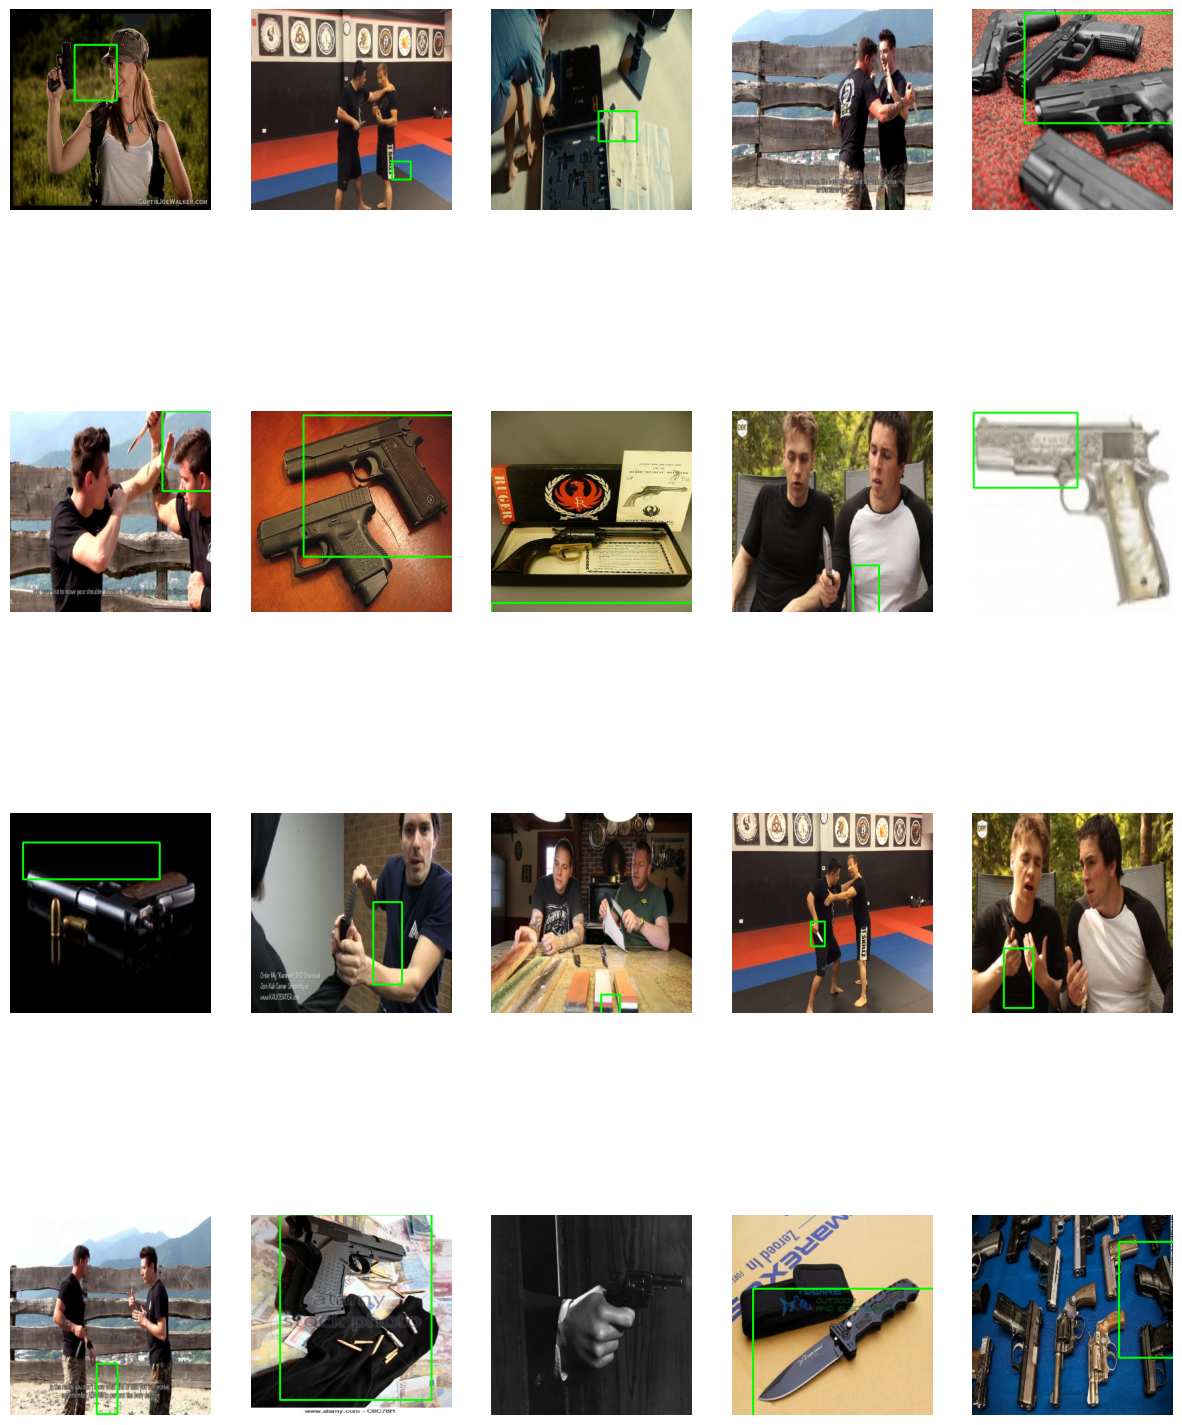

In [50]:
# Create a Matplotlib figure
plt.figure(figsize=(15, 20))

# Use a sample of 20 random indices from the available image_paths
random_range = random.sample(range(len(image_paths)), 20)

for itr, i in enumerate(random_range, 1):
    # Get the image path and load it
    img_path = image_paths[i]
    img = cv2.imread(img_path)
    
    if img is None:
        continue  # Skip if image failed to load

    # Resize image to 300x300 and normalize it
    img = cv2.resize(img, (300, 300))
    img = img.astype("float32") / 255.0


    # Extract bounding box and scale it to match the image size
    a1, b1, a2, b2 = boxes[i]
    x1 = int(a1 * 300)
    y1 = int(b1 * 300)
    x2 = int(a2 * 300)
    y2 = int(b2 * 300)

    # Draw the bounding box
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Plot the image
    plt.subplot(4, 5, itr)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')


In [51]:
print("🔢 Total images:", len(image_paths))
print("🟩 Total labels:", len(labels))
print("📦 Total bounding boxes:", len(boxes))


🔢 Total images: 5226
🟩 Total labels: 5226
📦 Total bounding boxes: 5226


In [52]:
from sklearn.model_selection import train_test_split

train_image_paths, val_image_paths, train_labels, val_labels, train_boxes, val_boxes = train_test_split(
    image_paths, labels, boxes, test_size=0.1, random_state=43
)

print('✅ Split complete.')
print(f'Training: {len(train_image_paths)}, Validation: {len(val_image_paths)}')


✅ Split complete.
Training: 4703, Validation: 523


In [53]:
from tensorflow.keras.utils import Sequence
import cv2
import numpy as np

class WeaponDataGenerator(Sequence):
    def __init__(self, image_paths, labels, boxes, batch_size=8, image_size=300, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.boxes = boxes
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        # Get batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Initialize batches
        batch_images = []
        batch_labels = []
        batch_boxes = []

        # Process each image in the batch
        for i in batch_indices:
            img = cv2.imread(self.image_paths[i])
            img = cv2.resize(img, (self.image_size, self.image_size))
            img = img.astype("float32") / 255.0

            batch_images.append(img)
            batch_labels.append(self.labels[i])
            batch_boxes.append(self.boxes[i])

        # Convert to NumPy arrays
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)
        batch_boxes = np.array(batch_boxes)

        return batch_images, {
            "class_output": batch_labels,
            "box_output": batch_boxes
        }

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [54]:
train_generator = WeaponDataGenerator(train_image_paths, train_labels, train_boxes, batch_size=8)
val_generator = WeaponDataGenerator(val_image_paths, val_labels, val_boxes, batch_size=8)

In [55]:
import keras 
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model

from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import SGD
image_size=300

In [56]:
# Create a NASNetMobile model as a base feature extractor (pretrained CNN)

N_mobile = tf.keras.applications.NASNetMobile(
    input_tensor=Input(shape=(image_size, image_size, 3)),  # Define the input shape (300x300 RGB image)
    include_top=False,                                      # Exclude the top classification layer (we’ll add our own output layers)
    weights='imagenet'                                      # Load pretrained weights trained on ImageNet
)

In [57]:
def create_model(no_of_classes):

    # Freeze all layers in NASNetMobile to prevent them from being updated during training
    N_mobile.trainable = False

    # Get the output of the base NASNetMobile model
    base_model_output = N_mobile.output

    # Apply Global Average Pooling to reduce the 4D feature map to a 2D vector
    flattened_output = GlobalAveragePooling2D()(base_model_output)

    # Just for debugging: print the shape of the pooled feature vector
    print(flattened_output.shape)

    # ====== Classification Branch ======

    # Fully connected layers to predict the class of the object
    class_prediction = Dense(256, activation="relu")(flattened_output)
    class_prediction = Dense(128, activation="relu")(class_prediction)
    class_prediction = Dropout(0.2)(class_prediction)  # Dropout to reduce overfitting
    class_prediction = Dense(64, activation="relu")(class_prediction)
    class_prediction = Dropout(0.2)(class_prediction)
    class_prediction = Dense(32, activation="relu")(class_prediction)

    # Final classification output layer (softmax for multi-class classification)
    class_prediction = Dense(no_of_classes, activation='softmax', name="class_output")(class_prediction)

    # ====== Bounding Box Regression Branch ======

    # Fully connected layers to predict bounding box coordinates (xmin, ymin, xmax, ymax)
    box_output = Dense(256, activation="relu")(flattened_output)
    box_output = Dense(128, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output)
    box_output = Dense(64, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output)
    box_output = Dense(32, activation="relu")(box_output)

    # Final output layer for bounding boxes — 4 values (all between 0 and 1 using sigmoid)
    box_predictions = Dense(4, activation='sigmoid', name="box_output")(box_output)

    # Create a Keras Model that takes the NASNet input and gives two outputs:
    # one for bounding box and one for class prediction
    model = Model(inputs=N_mobile.input, outputs=[box_predictions, class_prediction])

    return model

In [58]:
model = create_model(2)
model

(None, 1056)


<Functional name=functional_3, built=True>

In [59]:
# Define the loss functions for each output of the model.
# - "box_output": uses mean squared error (MSE) for bounding box regression.
# - "class_output": uses sparse categorical crossentropy for multi-class classification (labels are integers).
losses = { 
    "box_output": "mean_squared_error",
    "class_output": "sparse_categorical_crossentropy"
}

# Set the importance (weight) of each loss during training.
# Here, both outputs are equally important with a weight of 1.0 each.
loss_weights = {
    "box_output": 1.0, 
    "class_output": 1.0
}

# Specify evaluation metrics for each output:
# - "class_output": monitor classification accuracy.
# - "box_output": monitor mean squared error (MSE) of bounding box predictions.
metrics = {
    "class_output": "accuracy", 
    "box_output":  "mse"
}

# Use EarlyStopping to stop training early if the validation loss doesn't improve.
# - It waits 40 epochs (patience) for improvement.
# - When stopping, it restores the best weights seen during training.
stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",        # Monitor validation loss
    min_delta=0.0001,          # Minimum change to qualify as an improvement
    patience=40,               # Stop after 40 epochs without improvement
    restore_best_weights=True # Load the best weights before stopping
)

# Use ReduceLROnPlateau to reduce the learning rate if validation loss stops improving.
# - Helps the model converge more smoothly by lowering learning rate when stuck.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",       # Monitor validation loss
    factor=0.0002,            # Reduce learning rate by this factor
    patience=30,              # Wait 30 epochs without improvement before reducing
    min_lr=1e-7,              # Don't go lower than this learning rate
    verbose=1                 # Print when learning rate is updated
)

# Initialize the optimizer: Stochastic Gradient Descent (SGD)
# - learning_rate = 0.001
# - momentum = 0.9 for smoother convergence
opt = SGD(learning_rate=1e-3, momentum=0.9)

# Compile the model with:
# - SGD optimizer
# - Specified losses for each output
# - Loss weights to balance them
# - Metrics to monitor during training
model.compile(
    optimizer=opt,
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics
)

In [60]:
# Train the model using GPU (if available)
with tf.device('/device:GPU:0'):  # Use GPU for faster training
    history = model.fit(
        train_generator,            # Training generator
        validation_data=val_generator,  # Validation generator
        epochs=70,                  # Number of epochs
        callbacks=[reduce_lr, stop]  # Learning rate scheduler and early stopping
    )

Epoch 1/70


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


588/588 ━━━━━━━━━━━━━━━━━━━━ 95s 101ms/step - box_output_mse: 0.4764 - class_output_accuracy: 0.9338 - loss: 0.6870 - val_box_output_mse: 0.2752 - val_class_output_accuracy: 0.9809 - val_loss: 0.3323 - learning_rate: 0.0010
Epoch 2/70
588/588 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - box_output_mse: 0.3682 - class_output_accuracy: 0.9791 - loss: 0.4206 - val_box_output_mse: 0.2646 - val_class_output_accuracy: 0.9924 - val_loss: 0.2963 - learning_rate: 0.0010
Epoch 3/70
588/588 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - box_output_mse: 0.3915 - class_output_accuracy: 0.9940 - loss: 0.4137 - val_box_output_mse: 0.2549 - val_class_output_accuracy: 0.9885 - val_loss: 0.2816 - learning_rate: 0.0010
Epoch 4/70
588/588 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - box_output_mse: 0.3589 - class_output_accuracy: 0.9962 - loss: 0.3730 - val_box_output_mse: 0.2462 - val_class_output_accuracy: 0.9924 - val_loss: 0.2711 - learning_rate: 0.0010
Epoch 5/70
588/588 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - box_output_mse: 0.

In [61]:
def plot(var1, var2, plot_name):
    # Get the loss/metric history from model training
    c1 = history.history[var1]
    c2 = history.history[var2]

    # Define the x-axis (epoch count)
    epochs = range(len(c1))

    # Plot both training and validation metrics
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, c1, 'b', label=var1)
    plt.plot(epochs, c2, 'r', label=var2)
    plt.title(plot_name)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

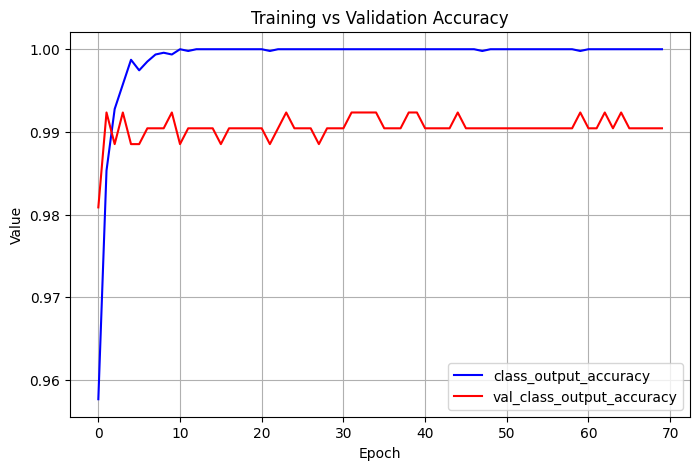

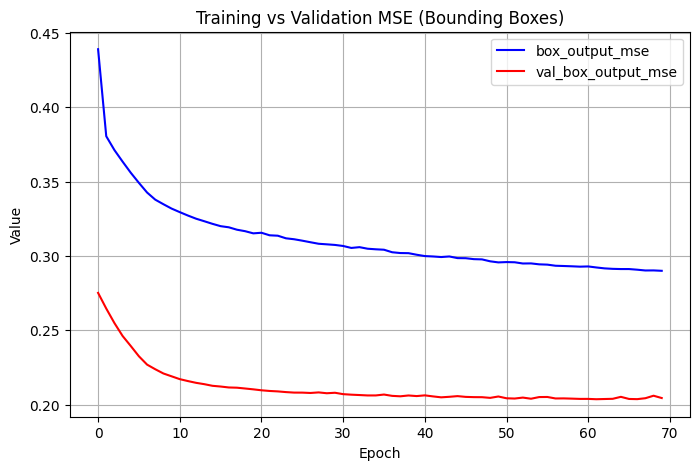

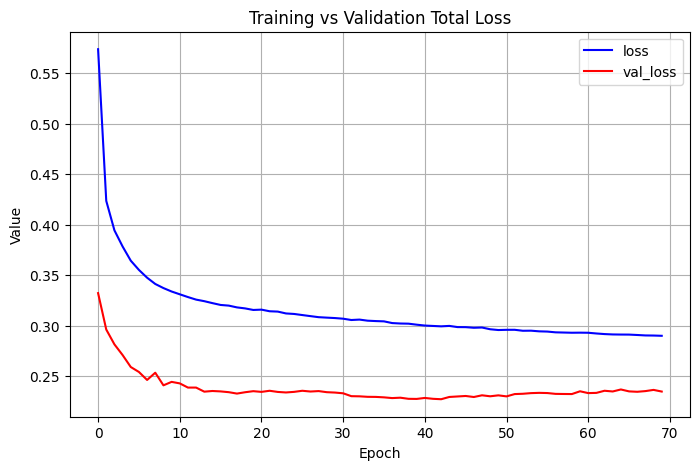

In [62]:
plot('class_output_accuracy', 'val_class_output_accuracy', 'Training vs Validation Accuracy')
plot('box_output_mse', 'val_box_output_mse', 'Training vs Validation MSE (Bounding Boxes)')
plot('loss', 'val_loss', 'Training vs Validation Total Loss')


The three graphs indicate that the model classifies weapons with high accuracy while struggling slightly with bounding box precision. The classification accuracy quickly reaches 100% on training and stabilizes around 99.1% on validation, showing excellent generalization. The bounding box MSE steadily decreases but maintains a gap between training and validation, suggesting label inconsistencies or easier validation samples. 

The total loss graph confirms this trend, with validation loss plateauing after epoch 35. Training beyond 40–50 epochs yields minimal gains and earlier stopping would likely maintain performance while reducing overfitting risk.

17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 663ms/step
✅ Classification Accuracy: 0.9904


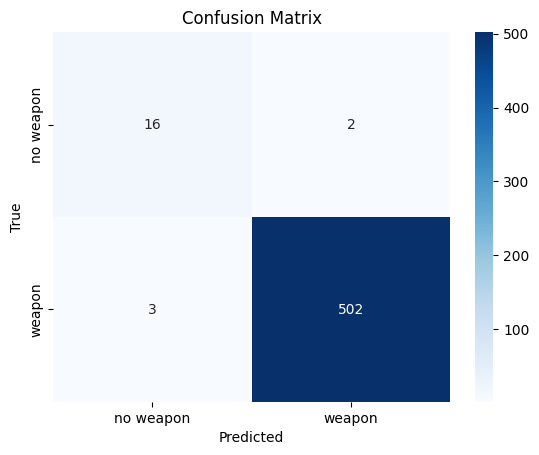

In [63]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 👣 Step 1: Load and preprocess images
def load_and_preprocess_images(image_paths, target_size=(300, 300)):
    processed_images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, target_size)
            img = img.astype("float32") / 255.0
            processed_images.append(img)
    return np.array(processed_images)

val_images = load_and_preprocess_images(val_image_paths)

# 👣 Step 2: Predict
y_pred_probs = model.predict(val_images)[1]
y_pred = np.argmax(y_pred_probs, axis=-1)

# 👣 Step 3: True labels
y_true = np.array(val_labels)

# 👣 Step 4: Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Classification Accuracy: {accuracy:.4f}")

# 👣 Step 5: Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_list, yticklabels=class_list)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# True labels and predictions (already computed)
# y_true = val_labels
# y_pred = np.argmax(model.predict(val_images)[1], axis=-1)

# Compute metrics
accuracy = accuracy_score(val_labels, y_pred)
precision = precision_score(val_labels, y_pred)
recall = recall_score(val_labels, y_pred)
f1 = f1_score(val_labels, y_pred)

# Print results
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")


✅ Accuracy:  0.9904
✅ Precision: 0.9960
✅ Recall:    0.9941
✅ F1 Score:  0.9950


In [65]:
#Save your model here in .h5 format.
model.save('caltech_normal.h5')

In [ ]:
# ONLY IF YOU WANT TO LOAD THE MODEL WITHOUT TRAINING IT AGAIN
from tensorflow.keras.models import load_model

model = load_model('caltech_normal.h5')
print("✅ Model loaded successfully")


In [66]:
global label_names
 
# Must be same as the Annotations list we used
label_names = sorted(class_list)

In [67]:
def preprocess(img, image_size=300):
    # Resize the image to the target size (e.g., 300x300) to match the input shape of the model
    image = cv2.resize(img, (image_size, image_size))
    
    # Convert the color space from BGR (OpenCV default) to RGB (used by most ML models)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Normalize the pixel values by dividing by 255 to bring them in the range [0, 1]
    # This is important because most models are trained with this normalization
    image = image.astype("float") / 255.0
    
    # Expand the dimensions of the image to include a batch size of 1
    # This is necessary because models expect input to be in the format (batch_size, height, width, channels)
    image = np.expand_dims(image, axis=0)
    
    return image

In [68]:
def postprocess(image, results):
    # The model's predictions are split into two parts:
    # - bounding_box: predicted bounding box coordinates (normalized between 0 and 1)
    # - class_probs: predicted class probabilities (the likelihood of each class)
    bounding_box, class_probs = results
    
    # Find the index of the class with the highest probability (most likely class)
    class_index = np.argmax(class_probs)
    
    # Get the label of the predicted class using the index from the label_names list
    class_label = label_names[class_index]
    
    # Get the height (h) and width (w) of the image to scale the bounding box coordinates
    h, w = image.shape[:2]

    # Extract the bounding box coordinates from the prediction
    x1, y1, x2, y2 = bounding_box[0]
    
    # Convert the bounding box coordinates from relative values (0-1) to actual pixel values
    x1 = int(w * x1)  # Convert x1 to pixel value based on width
    x2 = int(w * x2)  # Convert x2 to pixel value based on width
    y1 = int(h * y1)  # Convert y1 to pixel value based on height
    y2 = int(h * y2)  # Convert y2 to pixel value based on height
    
    # Return the predicted class label, the converted bounding box coordinates, and the class probabilities
    return class_label, (x1, y1, x2, y2), class_probs

In [69]:
def predict(image, returnimage=False, scale=0.9):
    # Process the input image
    processed_image = preprocess(image)

    # Predict with the model
    results = model.predict(processed_image)

    # Postprocess
    label, (x1, y1, x2, y2), confidence = postprocess(image, results)

    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 100), 2)

    # Format confidence
    confidence_score = np.max(confidence)  # Get top class confidence

    # Put label and confidence
    cv2.putText(
        image, 
        f'{label}: {confidence_score:.2f}',  # ✅ FIXED this line
        (x1, y2 + 30), 
        cv2.FONT_HERSHEY_COMPLEX, 
        scale, 
        (200, 300, 100), 
        2
    )

    # Show image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Prediction")
    plt.show()


    # Optional: return image if needed
    if returnimage:
        return image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
🔍 Predicted label: weapon
📦 Bounding Box: 995 597 1294 792
✅ Confidence score: 1.0


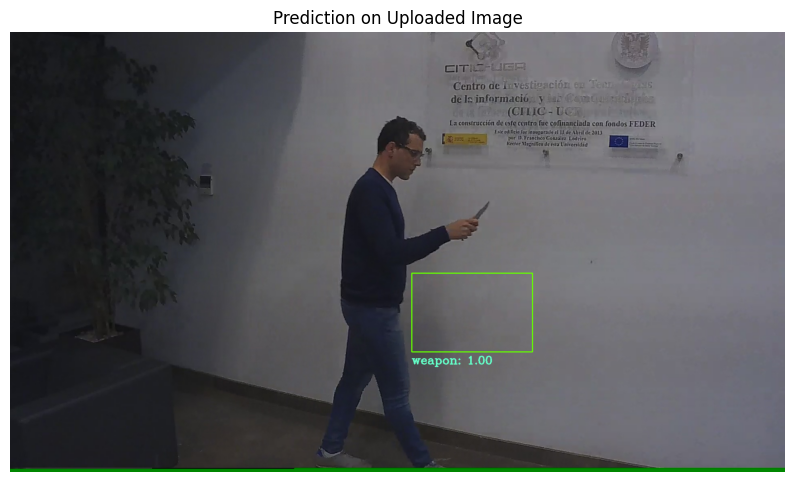

In [85]:
# 1. Load your image
image = cv2.imread('/kaggle/input/knifeman/our.jpg')

# 2. Preprocess it for the model
processed_image = preprocess(image)

# 3. Get model predictions
results = model.predict(processed_image)

# 4. Post-process to extract label, box, and confidence
label, (x1, y1, x2, y2), confidence = postprocess(image, results)

# 5. Print details
print("🔍 Predicted label:", label)
print("📦 Bounding Box:", x1, y1, x2, y2)
print("✅ Confidence score:", np.max(confidence))

# 6. (Optional) Visualize the result manually
cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 100), 2)
cv2.putText(image, f'{label}: {np.max(confidence):.2f}', (x1, y2 + 30),
            cv2.FONT_HERSHEY_COMPLEX, 0.9, (200, 300, 100), 2)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Prediction on Uploaded Image")
plt.show()


The model we employed is a multi-output convolutional neural network (CNN) trained to perform two tasks simultaneously: binary classification (weapon vs. no weapon) and bounding box regression for localization. The classification branch analyzes the entire image to determine the presence of a weapon based on learned visual features such as shape and context, while the bounding box branch attempts to localize the weapon based on training annotations. In the image shown, the model correctly identifies the presence of a weapon with high confidence (confidence score = 1.0), but the bounding box is incorrectly placed, not surrounding the actual weapon. 

This discrepancy highlights a known issue: while the classifier performs robustly by generalizing from global features, the bounding box predictor is highly sensitive to the quality of training labels. We retained this image as a clear demonstration of the model’s ability to classify correctly despite poor spatial localization, emphasizing that the classification branch functions independently from the accuracy of the bounding box data.